### 模型1   词典统计+ML算法

因为userid在test中不一样，先不考虑。

因为要求输出row_id和shop_id，那么先训练时生成一个dict，存储经纬度信息，就可以得到第一版结果。

然后根据wifi top3（或者可以考虑两个str的相似度），确定楼层信息。

#### 1.词典统计 经纬度

In [1]:
############# 1.数据预处理 ################
import numpy as np
import tensorflow as tf
import pandas as pd
from pandas import Series,DataFrame

train_shop = pd.read_csv(r"F:/data/shop/训练数据-ccf_first_round_shop_info.csv")
train_user = pd.read_csv(r"F:/data/shop/训练数据-ccf_first_round_user_shop_behavior.csv")
test = pd.read_csv(r"F:/data/shop/AB榜测试集-evaluation_public.csv")

In [85]:
#获取经纬度对应shopID的dict
lola_shop = {}
for ix, row in train_shop.iterrows():
    lo = round(row['longitude'],5)
    la = round(row['latitude'],5)
    lola_shop[(lo,la)] = lola_shop.get((lo,la),[]) + [row['shop_id']]
print(len(lola_shop))

from random import choice
random_value = lola_shop[choice(list(lola_shop.keys()))]
print(random_value)


7097
['s_877825']


In [4]:
#获取shopID对应wifiINFO的dict
shop_wifi = {}
for ix, row in train_user.iterrows():
    shop_wifi[row['shop_id']] = shop_wifi.get(row['shop_id'],[]) + [row['wifi_infos']]
print(len(shop_wifi))

print(shop_wifi[random_value[0]])

8477
['b_27796926|-72|false;b_55240327|-90|false;b_5892313|-47|false;b_46383841|-38|false;b_51359718|-88|false;b_50320600|-82|false;b_55655188|-79|false;b_47354211|-81|false;b_50080313|-84|false;b_55021924|-84|false', 'b_4640671|-83|false;b_62717|-68|false;b_4640670|-84|false;b_4640614|-86|false;b_62553|-80|false;b_26382620|-84|false;b_4640672|-84|false;b_26382621|-83|false;b_62709|-77|false;b_26382619|-84|false', 'b_5892313|-47|false;b_47354211|-81|false;b_27796926|-72|false;b_55655188|-79|false;b_46383841|-38|false;b_50080313|-84|false;b_55021924|-84|false;b_51359718|-88|false;b_55240327|-90|false;b_50320600|-82|false', 'b_4640670|-84|false;b_26382620|-84|false;b_4640671|-83|false;b_26382621|-83|false;b_62709|-77|false;b_26382619|-84|false;b_62717|-68|false;b_4640672|-84|false;b_62553|-80|false;b_4640614|-86|false', 'b_34365765|-88|false;b_34365766|-79|false;b_38892150|-74|false;b_31574947|-71|false;b_34721370|-69|false;b_9985189|-71|false;b_34365767|-76|false;b_62708|-83|false;b_627

### 先观察下wifi数量情况

In [7]:
wifi_num = []
for value in shop_wifi.values():
    wifi_num.append(len(value))
print('done')

done


In [10]:
print(max(wifi_num))
print(min(wifi_num))
print(np.mean(wifi_num))
print(wifi_num.count(1))

5018
1
134.247375251
420


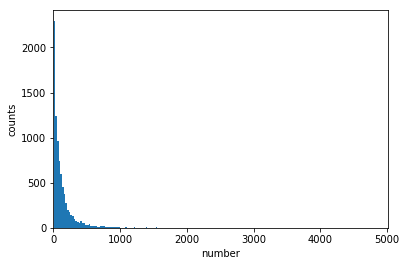

In [38]:
import matplotlib.pyplot as plt
def draw_hist(nums):
    plt.hist(nums,200)
    plt.xlim(0,5020)
    
    plt.xlabel('number')
    plt.ylabel('counts')

    plt.show()

draw_hist(wifi_num)

### 非常不平衡，所以还是先预处理。
取前K个信号强的wifi，不足的就补齐（复制最弱（强）的）

In [70]:
# 处理wifi
### 先处理不含true的
# 每家shop，不同的list先处理，提取信号最强的5个
# 再合并不同的list，取出现次数最多的5个，作为商店的dict wifi值
### 若含true，则统计次数最多的前5个，不够再计算出现次数最多的，凑够5个
#e.g:'b_27796926|-72|false;b_55240327|-90|false;b_5892313|-47|false;b_46383841|-38|false;b_51359718|-88|false;'

def wifi2top5(wifi_infos):
    wifi_list = wifi_infos.split(';')
    def sortWifi(wifiStr):
        wifi_num = int(wifiStr.split('|')[1])
        return wifi_num
    if len(wifi_list) < 5:
        sort_list = sorted(wifi_list, key=sortWifi)[::-1]
        top5_list = [sort_list[0]]*(5-len(wifi_list)) + sort_list
    elif len(wifi_list) > 5:
        sort_list = sorted(wifi_list, key=sortWifi)[::-1]
        top5_list = sort_list[:5]
    else:
        top5_list = wifi_list
    return top5_list

import re
def show_wifi_old2new(shop_wifi_old):
    shop_wifi_new = {}
    new_list = []
    for key,value in shop_wifi_old.items():
        wifi_list = []
        for wifi_info in value:
            wifi_list.extend(wifi2top5(wifi_info))
        
        #用正则替换掉数字（后期可以考虑处理数字 相近的合并）
        delnum = re.compile('-[0-9]+')
        wifi_list_noNum = []
        for i in wifi_list:
            s = re.sub(delnum,'',i)
            #re.sub(pattern, repl, string, count=0, flags=0)
            #在字符串 string 中找到匹配正则表达式 pattern 的所有子串，用另一个字符串 repl 进行替换。
            #如果没有找到匹配 pattern 的串，则返回未被修改的 string。Repl 既可以是字符串也可以是一个函数。
            wifi_list_noNum.append(s)
        wifi_sorted = {}
        for i in wifi_list_noNum:
            wifi_sorted[i] = wifi_sorted.get(i,0)+1
            
        #wifi_top5 = [ (x,y) for (x,y) in sorted(wifi_sorted.items(),key = lambda x: x[1])][::-1][:5]
        wifi_top5 = [ x for (x,y) in sorted(wifi_sorted.items(),key = lambda x: x[1])][::-1][:5]
        shop_wifi_new[key] = wifi_top5
    return shop_wifi_new

shop_wifi_new = show_wifi_old2new(shop_wifi)
print(len(shop_wifi_new))
print(shop_wifi_new[random_value[0]])

8477
['b_34721370||false', 'b_9985189||false', 'b_34234365||false', 'b_31574947||false', 'b_62716||false']


In [87]:
# 根据wifi相似度给不同shop评分
def compare2list_1(list1,list2):
    score = 0
    for i in list2:
        if i in list1:
            score += 100
    return score

def wifi2score(shop_wifi_list,wifi_info):
    #shop_wifi_list : (list)include k = 5 wifi infos
    #wifi_info : (str)wifi infos of this test item
    this_wifi_top5 = wifi2top5(wifi_info)
    this_wifi_top5_new = []
    for wifi in this_wifi_top5:
        delnum = re.compile('-[0-9]+')
        s = re.sub(delnum,'',wifi)
        this_wifi_top5_new.append(s)
    ### 核心 ###
    #比较训练时存储的shop_wifi_list（包含五条信号最强中出现频次最高的wifi）和当前test条目的this_wifi_top5_new（前5条信号最强的wifi）比较
    #方案1
    score = compare2list_1(shop_wifi_list,this_wifi_top5_new)
    return score
    
def best_score_shop(shop_id_list,wifi_info):
    best_shop = shop_id_list[0]
    best_score = wifi2score(shop_wifi_new[shop_id_list[0]], wifi_info)
    for i in range(1,len(shop_id_list)):
        thisScore = wifi2score(shop_wifi_new[shop_id_list[i]], wifi_info)
        if thisScore > best_score:
            best_score = thisScore
            best_shop = shop_id_list[i]       
    return best_shop

### 报错 keyerror
呵呵，忙活半天，结果test中的经纬度和训练机中的不一样。。。

先不管了。。只计算有的

嗯，裁掉多余的位数，统一弄成5位，貌似5位代表1米左右

还是太少了，还是考虑算法解决吧，先用knn试试

In [ ]:
###### 处理 lola不在训练中的数据 ######
def new_shop(row_info):
    # 输入当前test的一条项目信息
    # 输出最可能的shop id
    pass
    return shop_id

In [96]:
#### result ###
result = {}
for ix, row in test.iterrows():
    if ix % 5000 == 0:
        print('.',end='')
    lola = (round(row['longitude'],5),round(row['latitude'],5))
    wifi_info = row['wifi_infos']
    try:
        possibie_shop = lola_shop[lola]
        if len(possibie_shop) == 1:
            result[row['row_id']] = possibie_shop[0]
        else:
            result[row['row_id']] = best_score_shop(possibie_shop,wifi_info)
    except:
        possibie_shop = new_shop(row)
        result[row['row_id']] = possibie_shop

print('done')

.****************************************************************************************************************************************************************************************************************************************************************************+*********************************************************************************************************************************************************************************************************************************************************************+*********************************************************************************************************************************************************************+**************************************************************************************************************************************************************************************************************************************************************************************************************

*******************************************************************************************************************************************************************************************+**************************************************************************************************************************************************************************************************************************************************************************************************************************+***********+************************************************************************************************************+****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

******************************************************************+******++***************+************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+**********************************************************************************************************************************************************************************************+*************************************************+****************************+******************************************+**+****************************

*****+********************************************************************************************************************************************************************************************************************+************************************************************************************************************************************************************************************************************************************************************************************************************************************+**************************************************************+****************************************************+*********************+****+**************************************************************************************************************************************************************************************+************************************************************************+*********************************************************

****************************************************************************************************************************+*******************************************************************************************************************************************************************************+******************************************+**********************************************************************************************************************************************************************************************************************************************+******************************************************************************************************************************************+**************************************************************************************************************************************************************************************************************************************************************************************

*****************************************************************************************************************************************+**********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

********************************************************+**************************************************************************************************************************************************************************************************************************************************************************************.***********************************+*********************************************************************************************************************************************************************************************************************************************************************************************+*******+***********************************************************************************************************************************+**********************************************************************************************************************************************************************************************************

*********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+*************************************************************************************************************************************************************************.******************************************+******************+**************************************************************+**************************************************************+****************************************************+***************************************************************************************************************************************************************************************************

********************************************************************************************************************************************************************************************************************************************************+***********************+********************************************************************************************************************+**********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

****************************************************************************************************************************************************************************************************+*************************************************+**************************************************************************************************************************************************************************************************************************************+**********************************************************+*****************************************************************+******************************************************************************************************************************************************************************************+******************************************************************************************************************************************************************************************************************

**********************************************************************************************+*******************************+*****************************************************************************************************+***************************************************************************************************************************************************************************************+************************************************************************************************************************************************************************************************************************************************************************+**********************************************************************************************************************************************************************************************************************************************************************************************************************************

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

*******************************************************************************************************************************************************************************************************************************************************************************************************************************+************************+***************************************************************************************************************************************************************************************************************************************************************************************************************+***************+*************************************************************************************************************************************************************************+*********************************************************************************************************************************************************************

**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************.*************************************************+***********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

*****************************************************************************************+**************************************************+***********************************************************************************************************************************************************************+**************************************************************************************************************************************************************************+******************************************************************************************************************************************************************************************************************************************************+******************************************************************************+**************************************************************************************************************************************************************************************************

*************************************************************************************************************************************************************************************************************+*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+******************************

*************************************************************************************++***********************************************************************************************************************************+***************************************************************************************************************************************************************************************.****************************************************************************************************************************************************************************************************************+*+*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+************************************

*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+************************************************************************************************************************************************************************************************************************************************************************************************+*********************************************************************************************************************************

*****************************************************************************+***********************************************************************************************************************************************************+********************************************************************************************************************************************************************+***********************************************************************************************************************************+*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

**********************************************************************+********************++*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+*******************************************************************************************************+***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

**********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************.*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

******************************+*****************************************************************************************+**************************************************************************************************************************************************************************************************************************************************************************************************+**************************************************************************************************+*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+*************************************************************************************************************************************

****************************************************************************************************************************************************************************************************************+**********************************************+*********************+*****************************************************************************************************************************************************+**************************************************************************************************************************************+*******************************************************************************************************************************************************************************************************************************************************************************************************************************+*********************************************************************************************************************

*****************************************************************************************************************************************************************************************************************+****************************************************************************************************+*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

*********************************************************************+*****************************************************************************************************************************+***+************************************************************************************************************************++*********************************************************************************************************************************************************************+********************************+*******************+************+**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

********************************************************************************************************************************************************************************************************************************************************+*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+*************+************************************************************************************************************************************************************************+************************************************.*************************************

*********************************************************************************************************************+*************************************************************************************************************************************************************************************************************************+***************************************************************************************************************************************************************************************************************************************************************************+********************************************************************************************************************************************************************************************************************************************************************************************************************+***************************************************************************************

*****************************+*********************************************************************************************************************************************************************************************************************************************************************+***************************************+**********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+*********************************************************************************************************************************************************************************************************************************************************

***************************************************************************************************************************************************************************************************************************************************************+***********************************************************************************+***************************************************************************************************************************************************************+*******************************************************************************************************************************************************************+*********************+****************************************************************************************************************************************************************************************************************+*********************************************************************************************************

***********************+********************************************************************************************************************+***********************************************************************************************************************************+*****************************************************************************************************************************************************************************************************************************************************************************************************************************************+**************************************************************************************************************************************************************************************************************************+*********+************************************************************************************************************************************************************************

*************************************************************************************************************+******************************************************************************************+*********************************.*************************************************************************************************************************************************+*************************+****************************+*************+*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+****************************************************************************************************+******+**************************************************************

*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+*************************************************************.***********************************************************************************

*****************************************************************************************************************************************************************************************************************************************************************************************************************+************************************************************************+**********************************************************************************+**********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+********************************

************************************+***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+**************************************************************************************************************************************+********************************************************************************************************************************************************************************************************************************************

****+*********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+**********************************************************************************+**************************************************************************************************************************

*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************+*********************+*****************************************************************************************************************************************************************************************************************************************+******************************************************************************************************************************************************************************

*****************************************************************************************************************************************************************************************************************************************************************************************************+***********************************************************.*******************************+*****+******************************************************+********************************************************************************************************************************************************************************************************************************************************************+****************************************************************************************************************************************************************************************************************************************************************************************************

********************************************************************************************************************************************************************************+*****************************************************************************************++********************************************************************************************************************+********+*************************************************************************************************+**************************************************************************************************************************************************************************************************************+****************************************************************************************************************+*************************************************+*********************************************************************************+********************************************************

KeyboardInterrupt: 

In [95]:
########### 4.save ###############

df_res = pd.DataFrame(list(result.items()), columns=['row_id','shop_id'])
df_res.to_csv(r"result.csv", index=False,header=True)

#### 2.词典统计 用户ID